In [1]:
cd ..

/home/alberto/Work/course_interpretability_deep_learning


# Multi-omics stratification on PDAC patients

In [2]:
import os
import pandas as pd
import numpy as np
import dill
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.seed import isolate_rng
import torch
from captum.attr import LayerConductance, NeuronConductance
import types

from src import settings
from utils import MultiViewDataset, transform_full_dataset
from optimization import Optimization
from explainability import plot_comparison_attributions_weights, plot_attribution_distribution, plot_feature_importance, layerconductance, neuronconductance

## Load dataset

In [3]:
methylation_data = pd.read_csv(settings.methylation_data_path, sep=";", index_col=0, decimal=",")
methylation_data.columns = methylation_data.columns.str.replace(".", "-")
methylation_data = methylation_data.T
methylation_data = methylation_data.astype(np.float32)
print("methylation_data.shape", methylation_data.shape)
methylation_data.head()

methylation_data.shape (153, 301195)


,cg00000029,cg00000236,cg00000289,cg00000292,cg00000321,cg00000622,cg00000658,cg00000714,cg00000721,cg00000734,...,ch.9.2262725R,ch.9.2285199R,ch.9.2298007R,ch.9.2473665R,ch.9.357218F,ch.9.377428R,ch.9.691424R,ch.9.837340R,ch.9.898515R,ch.9.991104F
TCGA-2J-AAB6,0.157951,0.836226,0.710511,0.560780,0.239194,0.016433,0.864604,0.087681,0.938775,0.061008,...,0.103136,0.053757,0.032478,NaN,0.064965,0.049776,0.115268,0.095954,0.084203,NaN
TCGA-2J-AAB8,0.300754,0.782242,0.574296,0.670286,0.424310,0.014747,0.885958,0.112524,0.930765,0.037198,...,0.028180,0.054483,0.022736,NaN,0.060835,0.036434,0.160082,0.059216,0.065342,0.166304
TCGA-2J-AAB9,0.257807,0.846522,0.534748,0.688073,0.295597,0.014649,0.895039,0.167297,0.940112,0.058407,...,0.059313,0.063187,0.032581,NaN,0.055342,0.069086,0.128546,0.120015,0.074940,NaN
TCGA-2J-AABA,0.239086,0.789457,0.474723,0.705372,0.530321,0.016919,0.884874,0.129581,0.910885,0.062167,...,0.122677,0.056068,0.023190,0.109351,0.056015,0.053238,0.082979,0.057172,0.045781,0.121676
TCGA-2J-AABE,0.168622,0.841684,0.591205,0.623799,0.322576,0.014408,0.898202,0.125415,0.941153,0.059365,...,0.046699,0.049177,0.032707,NaN,0.075854,0.062602,0.122072,0.082753,0.071240,NaN


In [4]:
rnaseq_data = pd.read_csv(settings.rnaseq_data_path, sep=";", index_col=0, decimal=",")
rnaseq_data = rnaseq_data.T
rnaseq_data = rnaseq_data.astype(np.float32)
print("rnaseq_data.shape", rnaseq_data.shape)
rnaseq_data.head()

rnaseq_data.shape (147, 20501)


,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
TCGA-2J-AAB6,82.549698,8.187100,0.0000,163.122803,1815.789551,8517.444336,1121.052612,1.169600,1.1696,834.502930,...,14.619900,269.005798,1053.216431,0.5848,683.625671,11696.491211,869.005798,601.754395,26.315800,0.0000
TCGA-2J-AAB8,56.930698,33.842499,0.0000,185.814301,16.921301,14413.913086,392.949493,9.400700,0.9401,801.880127,...,35.722698,356.286713,829.142212,3.7603,680.611023,5829.377441,828.202087,609.165710,85.546402,0.0000
TCGA-2J-AAB9,105.787804,21.436199,1.0718,166.709503,642.015015,24311.779297,1125.401855,50.375099,0.0000,862.808105,...,57.877800,381.564789,936.763123,1.0718,646.302307,8094.319336,1083.601318,573.419128,30.010700,0.0000
TCGA-2J-AABA,99.345497,18.788200,0.0000,99.276703,873.649597,10302.006836,633.161072,6.262700,18.7882,623.767029,...,52.606899,293.721588,1511.820923,1.2525,945.670898,4829.810547,1364.646851,793.486816,31.313601,0.6263
TCGA-2J-AABE,79.401901,3.083100,0.0000,134.564499,74.610802,11076.861328,710.343811,35.147202,0.0000,702.327698,...,56.728802,431.632507,1069.215454,0.6166,564.205322,7464.775879,832.434082,468.629608,48.096199,0.0000


In [5]:
samples = methylation_data.index.intersection(rnaseq_data.index)
methylation_data = methylation_data.loc[samples]
rnaseq_data = rnaseq_data.loc[samples]
assert methylation_data.index.equals(rnaseq_data.index)
Xs= [rnaseq_data, methylation_data]
print("common samples:", len(samples))

common samples: 147


In [6]:
date = "2023070315"
with open(os.path.join(settings.optimization_path, f'optimization_optuna_{date}.pkl'), 'rb') as file:
    optimization_study = dill.load(file)
optimization_results = pd.read_csv(os.path.join(settings.optimization_path, f"optimization_results_{date}.csv"))
best_trial = optimization_results.iloc[0]
print("optimization_results.shape", optimization_results.shape)
optimization_results.head()

optimization_results.shape (1220, 58)


,number,value,datetime_start,datetime_complete,duration,params_divisor_units,params_features_per_component,params_lambda_coeff,params_latent_space,params_n_clusters,...,user_attrs_val_dist_loss,user_attrs_val_dist_loss_list,user_attrs_val_loss,user_attrs_val_loss_list,user_attrs_val_loss_view_list,user_attrs_val_silhscore,user_attrs_val_silhscore_list,user_attrs_val_total_loss,user_attrs_val_total_loss_list,state
0,1127,0.281159,2023-07-07 07:01:25.882040,2023-07-07 07:08:24.600525,0 days 00:06:58.718485,2,10,0.014074,50,2.0,...,112.288543,"[80.92032623291016, 158.0206298828125, 182.946...",0.594707,"[0.5835521817207336, 0.6417752504348755, 0.592...","[0.5626613163948059, 0.6267521572113037]",0.281159,"[0.17513557, 0.20066147, 0.33802804, 0.1914916...",2.175859,"[1.7208877801895142, 2.867652177810669, 3.1697...",COMPLETE
1,1149,0.279001,2023-07-07 08:41:07.673127,2023-07-07 08:48:38.017987,0 days 00:07:30.344860,2,10,0.007898,50,2.0,...,122.397693,"[188.0741424560547, 101.92342376708984, 78.606...",0.596372,"[0.6067892909049988, 0.6313546895980835, 0.588...","[0.5653188920021057, 0.6274248051643372]",0.279001,"[0.29767722, 0.18416011, 0.34523594, 0.1691730...",1.563155,"[2.0907042026519775, 1.4374117851257324, 1.207...",COMPLETE
2,1196,0.269337,2023-07-07 12:47:37.526021,2023-07-07 12:55:08.465497,0 days 00:07:30.939476,2,10,0.013482,50,2.0,...,99.369842,"[111.77200317382812, 218.13812255859375, 86.58...",0.595154,"[0.5886245965957642, 0.6277905106544495, 0.585...","[0.5625463891029358, 0.6277625322341919]",0.269337,"[0.17461367, 0.19133604, 0.22703034, 0.2376199...",1.934152,"[2.0977280139923096, 3.569657564163208, 1.7522...",COMPLETE
3,1084,0.265154,2023-07-07 03:25:02.458722,2023-07-07 03:27:56.844037,0 days 00:02:54.385315,4,10,0.010966,50,2.0,...,35.438107,"[20.836471557617188, 53.32878494262695, 22.022...",0.596461,"[0.5911136269569397, 0.6372606158256531, 0.591...","[0.5633599877357482, 0.6295623540878296]",0.265154,"[0.25051585, 0.208064, 0.21120243, 0.29239604,...",0.987910,"[0.8248596787452698, 1.2237839698791504, 0.833...",COMPLETE
4,1130,0.264482,2023-07-07 07:17:42.352880,2023-07-07 07:24:47.307330,0 days 00:07:04.954450,2,10,0.010072,50,2.0,...,123.094148,"[197.2069854736328, 140.8181610107422, 55.0165...",0.594263,"[0.5875703692436218, 0.6417000889778137, 0.571...","[0.5615304493904114, 0.6269950985908508]",0.264482,"[0.21908401, 0.21233779, 0.10679189, 0.1546428...",1.834330,"[2.5816493034362793, 2.060253143310547, 1.1255...",COMPLETE


In [7]:
transformed_Xs = transform_full_dataset(Xs=Xs, fit_pipelines = False, results_folder = settings.results_path)
transformed_X = pd.concat(transformed_Xs, axis = 1)
features = pd.Series(np.concatenate([(view + "_" + X_.columns) for X_, view in zip(transformed_Xs, ["RNAseq", "Methylation"])]))
print("transformed_X.shape", transformed_X.shape)
transformed_X.head()

transformed_X.shape (147, 10240)


,A2ML1,A2M,A4GALT,AADAC,AAMP,AARS,ABCA1,ABCA2,ABCA3,ABCA5,...,cg27594157,cg27594756,cg27610821,cg27616227,cg27633530,cg27641961,cg27645259,cg27648738,cg27649073,cg27664689
TCGA-2J-AAB6,1.337566,-0.995322,0.709940,-0.482025,-0.994043,-0.500406,-0.617043,0.025660,-0.993760,-0.916834,...,1.172822,-0.158712,-0.823215,-1.693980,1.363548,-1.496673,2.282258,1.486526,-0.865494,-1.595479
TCGA-2J-AAB8,-0.263078,-0.312616,-0.466568,-0.092760,0.365986,-0.484396,-0.752298,-1.017359,-1.037290,-0.983338,...,-0.775050,-0.460455,-0.760774,-1.272152,0.102773,-0.765774,-0.597939,0.576464,0.719743,-0.701581
TCGA-2J-AAB9,0.293135,0.833378,0.716968,-0.244825,-0.678968,-0.453602,-0.894353,-0.992373,0.142981,0.175134,...,-0.048385,-0.226124,-0.866286,0.564234,-1.219404,1.289739,-0.342804,-1.038833,-0.102618,-0.528777
TCGA-2J-AABA,0.499244,-0.788701,-0.078421,-0.385282,0.184817,-0.670856,0.067303,1.108192,-0.937203,-0.121891,...,-0.836188,1.551527,-1.017153,0.405024,0.700272,-0.569468,-0.688826,-0.836018,-0.624695,-0.653387
TCGA-2J-AABE,-0.211745,-0.698987,0.046295,-0.167821,0.721762,-0.584655,-0.515060,0.903657,-0.765430,-1.021597,...,-1.046977,-0.314683,1.008485,0.421982,-1.224547,-0.489625,-0.628166,-0.558183,-0.415640,-0.751258


In [8]:
batch_size = best_trial["user_attrs_batch_size"]
full_data = MultiViewDataset(Xs=transformed_Xs)
full_dataloader = DataLoader(dataset=full_data, batch_size=32, shuffle=True)
with isolate_rng():
    total_results = Optimization().training(n_clusters = optimization_study.best_params["n_clusters"], latent_space=optimization_study.best_params["latent_space"],
                                            in_channels_list = eval(best_trial["user_attrs_num_features"]),
                                            hidden_channels_list = [view_hidden[1:] for view_hidden in eval(best_trial["user_attrs_num_units"])], 
                                            train_dataloader = full_dataloader, val_dataloader = full_dataloader, test_dataloader = full_dataloader,
                                            n_epochs = optimization_study.best_params["n_epochs"],
                                            log_every_n_steps = np.ceil(len(full_data) / batch_size).astype(int),
                                            lambda_coeff = optimization_study.best_params["lambda_coeff"])
model = total_results["model"]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasin

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at /home/alberto/Work/course_interpretability_deep_learning/.lr_find_84f51e0f-4073-4f57-afa8-cc31b80ce3ba.ckpt
Restored all states from the checkpoint at /home/alberto/Work/course_interpretability_deep_learning/.lr_find_84f51e0f-4073-4f57-afa8-cc31b80ce3ba.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder_0 | FCN        | 16.4 M
1 | decoder_0 | FCN        | 19.7 M
2 | encoder_1 | FCN        | 16.4 M
3 | decoder_1 | FCN        | 19.7 M
4 | encoder_2 | Sequential | 128 K 
5 | decoder_2 | FCN        | 135 K 
-----------------------------------------
72.4 M    Trainable params
0         Non-trainable params
72

In [12]:
target = 1
inputs = tuple([torch.tensor(Xs_.values) for Xs_ in transformed_Xs])
baselines = tuple([torch.zeros(Xs_.shape) for Xs_ in inputs])

In [13]:
layer = eval(f"model.autoencoder.encoder_{model.autoencoder.views}")
lc = LayerConductance(model.predict_step, layer[1], device_ids = model.cluster_centers_.device)
lc._attribute = types.MethodType(layerconductance._attribute, lc)

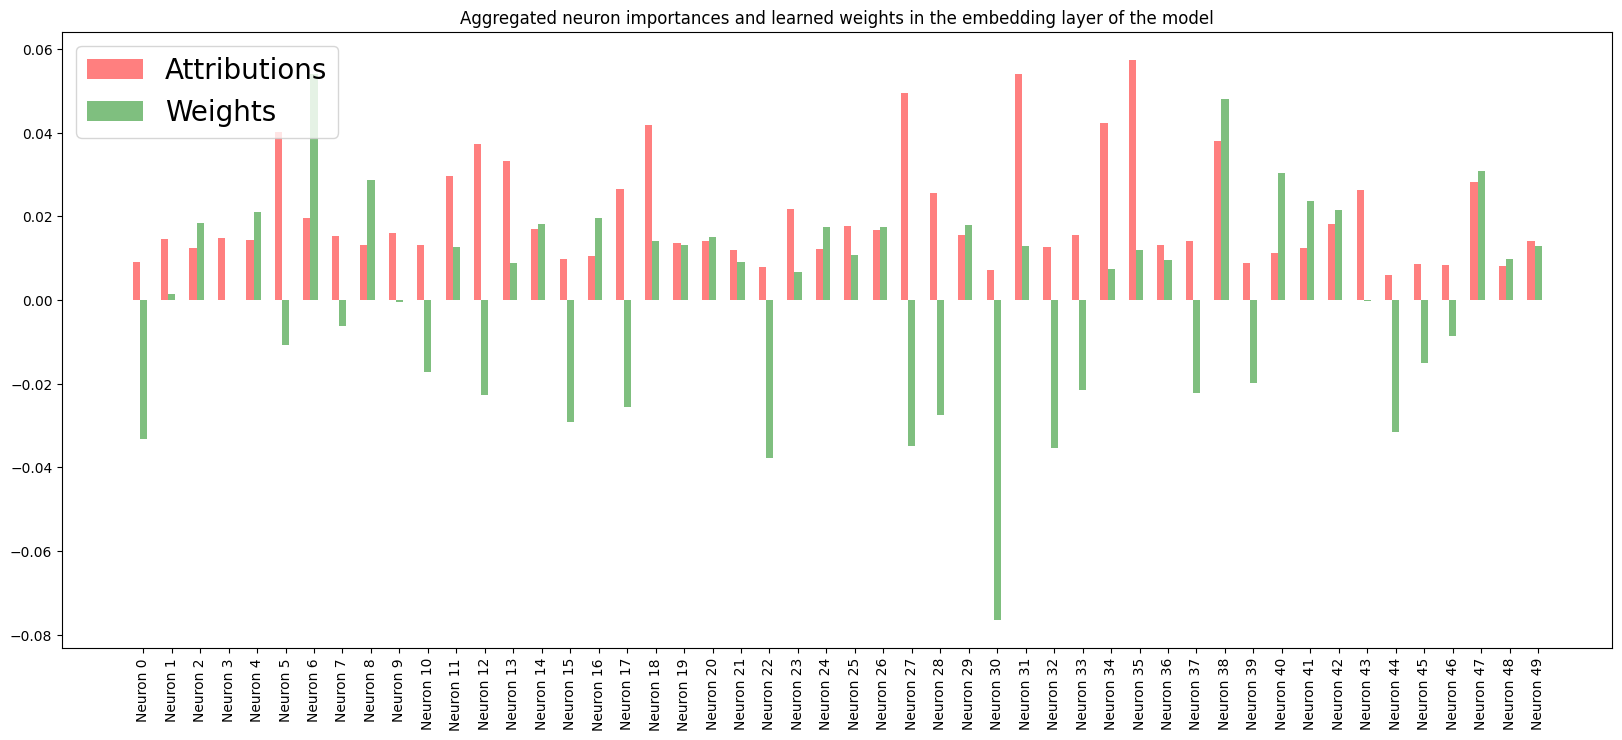

In [14]:
lc_attr_test = lc.attribute(inputs = inputs, baselines=baselines, target = target)
plot_comparison_attributions_weights(lc_attr = lc_attr_test.detach().numpy(), weights = layer[0].weight.detach().numpy(), layer_name = "embedding", figsize=(20, 8))

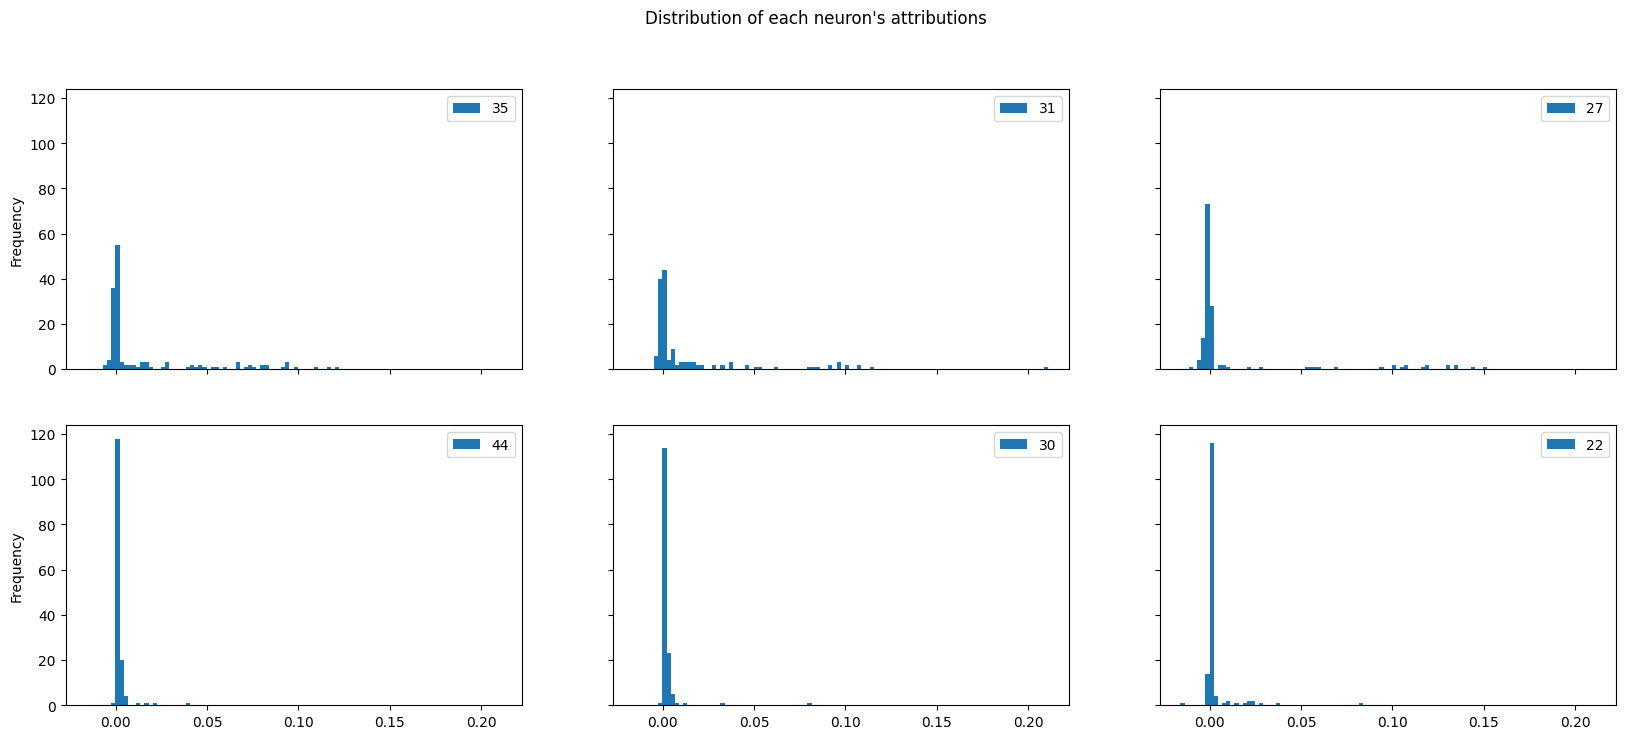

In [50]:
cond_vals = lc_attr_test.detach().numpy()
sorted_neurons = np.abs(cond_vals.mean(0)).argsort()[::-1].tolist()
plot_attribution_distribution(cond_vals = cond_vals, figsize = (20, 8), strong_features = sorted_neurons[:3], weak_features = sorted_neurons[-3:][::-1])

In [174]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Any, Callable, List, Tuple, Union, Dict, cast
from captum._utils.typing import TargetType
from torch import device, Tensor
from captum.attr._utils.approximation_methods import approximation_parameters
from captum.attr._utils.common import _reshape_and_sum
from captum._utils.common import (_expand_additional_forward_args, _expand_target, _format_additional_forward_args, _format_output, _format_inputs, _select_targets, 
    _sort_key_list, _reduce_list, _verify_select_neuron, _reduce_list)
from captum._utils.gradient import _forward_layer_distributed_eval, _extract_device_ids, apply_gradient_requirements, _neuron_gradients
from captum._utils.typing import ModuleOrModuleList
from torch.nn import Module
from inspect import signature
from collections import defaultdict
import threading
import torch


def _attribute(self, inputs: Tuple[Tensor, ...], baselines: Tuple[Union[Tensor, int, float], ...], neuron_selector: Union[int, Tuple[int, ...], Callable],
               target: TargetType = None, additional_forward_args: Any = None, n_steps: int = 50, method: str = "riemann_trapezoid", attribute_to_neuron_input: bool = False,
               step_sizes_and_alphas: Union[None, Tuple[List[float], List[float]]] = None,) -> Union[Tensor, Tuple[Tensor, ...]]:
    num_examples = inputs[0].shape[0]
    total_batch = num_examples * n_steps
    if step_sizes_and_alphas is None:
        # Retrieve scaling factors for specified approximation method
        step_sizes_func, alphas_func = approximation_parameters(method)
        step_sizes, alphas = step_sizes_func(n_steps), alphas_func(n_steps)
    else:
        _, alphas = step_sizes_and_alphas
    # Compute scaled inputs from baseline to final input.
    scaled_features_tpl = tuple(
        torch.cat([baseline + alpha * (input - baseline) for alpha in alphas], dim=0).requires_grad_()
        for input, baseline in zip(inputs, baselines)
    )

    additional_forward_args = _format_additional_forward_args(
        additional_forward_args
    )
    # apply number of steps to additional forward args
    # currently, number of steps is applied only to additional forward arguments
    # that are nd-tensors. It is assumed that the first dimension is
    # the number of batches.
    # dim -> (#examples * #steps x additional_forward_args[0].shape[1:], ...)
    input_additional_args = (
        _expand_additional_forward_args(additional_forward_args, n_steps + 1)
        if additional_forward_args is not None
        else None
    )
    expanded_target = _expand_target(target, n_steps + 1)

    # Conductance Gradients - Returns gradient of output with respect to
    # hidden layer and hidden layer evaluated at each input.
    layer_gradients, layer_eval, input_grads = compute_layer_gradients_and_eval(
        forward_fn=self.forward_func,
        layer=self.layer,
        inputs=scaled_features_tpl,
        target_ind=expanded_target,
        additional_forward_args=input_additional_args,
        gradient_neuron_selector=neuron_selector,
        device_ids=self.device_ids,
        attribute_to_layer_input=attribute_to_neuron_input,
    )

    mid_grads = _verify_select_neuron(layer_gradients, neuron_selector)
    scaled_input_gradients = tuple(
        input_grad
        * mid_grads.reshape((total_batch,) + (1,) * (len(input_grad.shape) - 1))
        for input_grad in input_grads
    )

    # Mutliplies by appropriate step size.
    scaled_grads = tuple(
        scaled_input_gradient.contiguous().view(n_steps, -1)
        * torch.tensor(step_sizes).view(n_steps, 1).to(scaled_input_gradient.device)
        for scaled_input_gradient in scaled_input_gradients
    )

    # Aggregates across all steps for each tensor in the input tuple
    total_grads = tuple(
        _reshape_and_sum(scaled_grad, n_steps, num_examples, input_grad.shape[1:])
        for (scaled_grad, input_grad) in zip(scaled_grads, input_grads)
    )

    if self.multiplies_by_inputs:
        # computes attribution for each tensor in input tuple
        # attributions has the same dimensionality as inputs
        attributions = tuple(
            total_grad * (input - baseline)
            for total_grad, input, baseline in zip(total_grads, inputs, baselines)
        )
    else:
        attributions = total_grads

    return attributions


def compute_layer_gradients_and_eval(forward_fn: Callable, layer: ModuleOrModuleList, inputs: Union[Tensor, Tuple[Tensor, ...]], target_ind: TargetType = None,
    additional_forward_args: Any = None, gradient_neuron_selector: Union[None, int, Tuple[Union[int, slice], ...], Callable] = None, device_ids: Union[None, List[int]] = None,
    attribute_to_layer_input: bool = False, output_fn: Union[None, Callable] = None,) -> Union[
    Tuple[Tuple[Tensor, ...], Tuple[Tensor, ...]],
    Tuple[Tuple[Tensor, ...], Tuple[Tensor, ...], Tuple[Tensor, ...]],
    Tuple[List[Tuple[Tensor, ...]], List[Tuple[Tensor, ...]]],]:
    with torch.autograd.set_grad_enabled(True):
        # saved_layer is a dictionary mapping device to a tuple of
        # layer evaluations on that device.
        saved_layer, output = _forward_layer_distributed_eval(
            forward_fn,
            inputs,
            layer,
            target_ind=target_ind,
            additional_forward_args=additional_forward_args,
            attribute_to_layer_input=attribute_to_layer_input,
            forward_hook_with_return=True,
            require_layer_grads=True,
        )
        
        assert output[0].numel() == 1, (
            "Target not provided when necessary, cannot"
            " take gradient with respect to multiple outputs."
        )

        device_ids = _extract_device_ids(forward_fn, saved_layer, device_ids)

        # Identifies correct device ordering based on device ids.
        # key_list is a list of devices in appropriate ordering for concatenation.
        # If only one key exists (standard model), key list simply has one element.
        key_list = _sort_key_list(
            list(next(iter(saved_layer.values())).keys()), device_ids
        )
        all_outputs: Union[Tuple[Tensor, ...], List[Tuple[Tensor, ...]]]
        if isinstance(layer, Module):
            all_outputs = _reduce_list(
                [
                    saved_layer[layer][device_id]
                    if output_fn is None
                    else output_fn(saved_layer[layer][device_id])
                    for device_id in key_list
                ]
            )
        else:
            all_outputs = [
                _reduce_list(
                    [
                        saved_layer[single_layer][device_id]
                        if output_fn is None
                        else output_fn(saved_layer[single_layer][device_id])
                        for device_id in key_list
                    ]
                )
                for single_layer in layer
            ]
        all_layers: List[Module] = [layer] if isinstance(layer, Module) else layer
        grad_inputs = tuple(
            layer_tensor
            for single_layer in all_layers
            for device_id in key_list
            for layer_tensor in saved_layer[single_layer][device_id]
        )
        saved_grads = torch.autograd.grad(torch.unbind(output), grad_inputs)

        offset = 0
        all_grads: List[Tuple[Tensor, ...]] = []
        for single_layer in all_layers:
            num_tensors = len(next(iter(saved_layer[single_layer].values())))
            curr_saved_grads = [
                saved_grads[i : i + num_tensors]
                for i in range(
                    offset, offset + len(key_list) * num_tensors, num_tensors
                )
            ]
            offset += len(key_list) * num_tensors
            if output_fn is not None:
                curr_saved_grads = [
                    output_fn(curr_saved_grad) for curr_saved_grad in curr_saved_grads
                ]

            all_grads.append(_reduce_list(curr_saved_grads))

        layer_grads: Union[Tuple[Tensor, ...], List[Tuple[Tensor, ...]]]
        layer_grads = all_grads
        if isinstance(layer, Module):
            layer_grads = all_grads[0]

        if gradient_neuron_selector is not None:
            assert isinstance(
                layer, Module
            ), "Cannot compute neuron gradients for multiple layers simultaneously!"
            inp_grads = _neuron_gradients(
                inputs, saved_layer[layer], key_list, gradient_neuron_selector
            )
            return (
                cast(Tuple[Tensor, ...], layer_grads),
                cast(Tuple[Tensor, ...], all_outputs),
                inp_grads,
            )
    return layer_grads, all_outputs  # type: ignore


def _forward_layer_distributed_eval(
    forward_fn: Callable,
    inputs: Any,
    layer: ModuleOrModuleList,
    target_ind: TargetType = None,
    additional_forward_args: Any = None,
    attribute_to_layer_input: bool = False,
    forward_hook_with_return: bool = False,
    require_layer_grads: bool = False,
) -> Union[
    Tuple[Dict[Module, Dict[device, Tuple[Tensor, ...]]], Tensor],
    Dict[Module, Dict[device, Tuple[Tensor, ...]]],
]:
    r"""
    A helper function that allows to set a hook on model's `layer`, run the forward
    pass and returns intermediate layer results, stored in a dictionary,
    and optionally also the output of the forward function. The keys in the
    dictionary are the device ids and the values are corresponding intermediate layer
    results, either the inputs or the outputs of the layer depending on whether we set
    `attribute_to_layer_input` to True or False.
    This is especially useful when we execute forward pass in a distributed setting,
    using `DataParallel`s for example.
    """
    saved_layer: Dict[Module, Dict[device, Tuple[Tensor, ...]]] = defaultdict(dict)
    lock = threading.Lock()
    all_layers: List[Module] = [layer] if isinstance(layer, Module) else layer

    # Set a forward hook on specified module and run forward pass to
    # get layer output tensor(s).
    # For DataParallel models, each partition adds entry to dictionary
    # with key as device and value as corresponding Tensor.
    def hook_wrapper(original_module):
        def forward_hook(module, inp, out=None):
            eval_tsrs = inp if attribute_to_layer_input else out
            is_eval_tuple = isinstance(eval_tsrs, tuple)

            if not is_eval_tuple:
                eval_tsrs = (eval_tsrs,)
            if require_layer_grads:
                apply_gradient_requirements(eval_tsrs, warn=False)
            with lock:
                nonlocal saved_layer
                # Note that cloning behaviour of `eval_tsr` is different
                # when `forward_hook_with_return` is set to True. This is because
                # otherwise `backward()` on the last output layer won't execute.
                if forward_hook_with_return:
                    saved_layer[original_module][eval_tsrs[0].device] = eval_tsrs
                    eval_tsrs_to_return = tuple(
                        eval_tsr.clone() for eval_tsr in eval_tsrs
                    )
                    if not is_eval_tuple:
                        eval_tsrs_to_return = eval_tsrs_to_return[0]
                    return eval_tsrs_to_return
                else:
                    saved_layer[original_module][eval_tsrs[0].device] = tuple(
                        eval_tsr.clone() for eval_tsr in eval_tsrs
                    )

        return forward_hook

    all_hooks = []
    try:
        for single_layer in all_layers:
            if attribute_to_layer_input:
                all_hooks.append(
                    single_layer.register_forward_pre_hook(hook_wrapper(single_layer))
                )
            else:
                all_hooks.append(
                    single_layer.register_forward_hook(hook_wrapper(single_layer))
                )
        output = _run_forward(
            forward_fn,
            inputs,
            target=target_ind,
            additional_forward_args=additional_forward_args,
        )
    finally:
        for hook in all_hooks:
            hook.remove()

    if len(saved_layer) == 0:
        raise AssertionError("Forward hook did not obtain any outputs for given layer")

    if forward_hook_with_return:
        return saved_layer, output
    return saved_layer


def _run_forward(forward_func: Callable, inputs: Any, target: TargetType = None, additional_forward_args: Any = None,) -> Tensor:
    forward_func_args = signature(forward_func).parameters
    if len(forward_func_args) == 0:
        output = forward_func()
        return output if target is None else _select_targets(output, target)

    # make everything a tuple so that it is easy to unpack without
    # using if-statements
    inputs = _format_inputs(inputs)
    additional_forward_args = _format_additional_forward_args(additional_forward_args)

    output = forward_func(inputs)
    return _select_targets(output, target)

In [51]:
neuron_cond = NeuronConductance(model.predict_step, layer[1], device_ids = model.cluster_centers_.device)
neuron_cond._attribute = types.MethodType(neuronconductance._attribute, neuron_cond)

In [84]:
def plot_feature_importance(features, top_n, values, neuron_selector, figsize= (12,6)):
    importances = torch.cat(values, 1).mean(0).detach().numpy()
    features = features.to_frame("feature")
    features["importance"] = importances
    features = features.sort_values("importance", ascending= False).iloc[:top_n]
    features = features.set_index("feature")
    features.plot(kind= "bar", xlabel = "Feature", title = f"Top {top_n} average feature importances for neuron {neuron_selector}", figsize=figsize, legend=None)

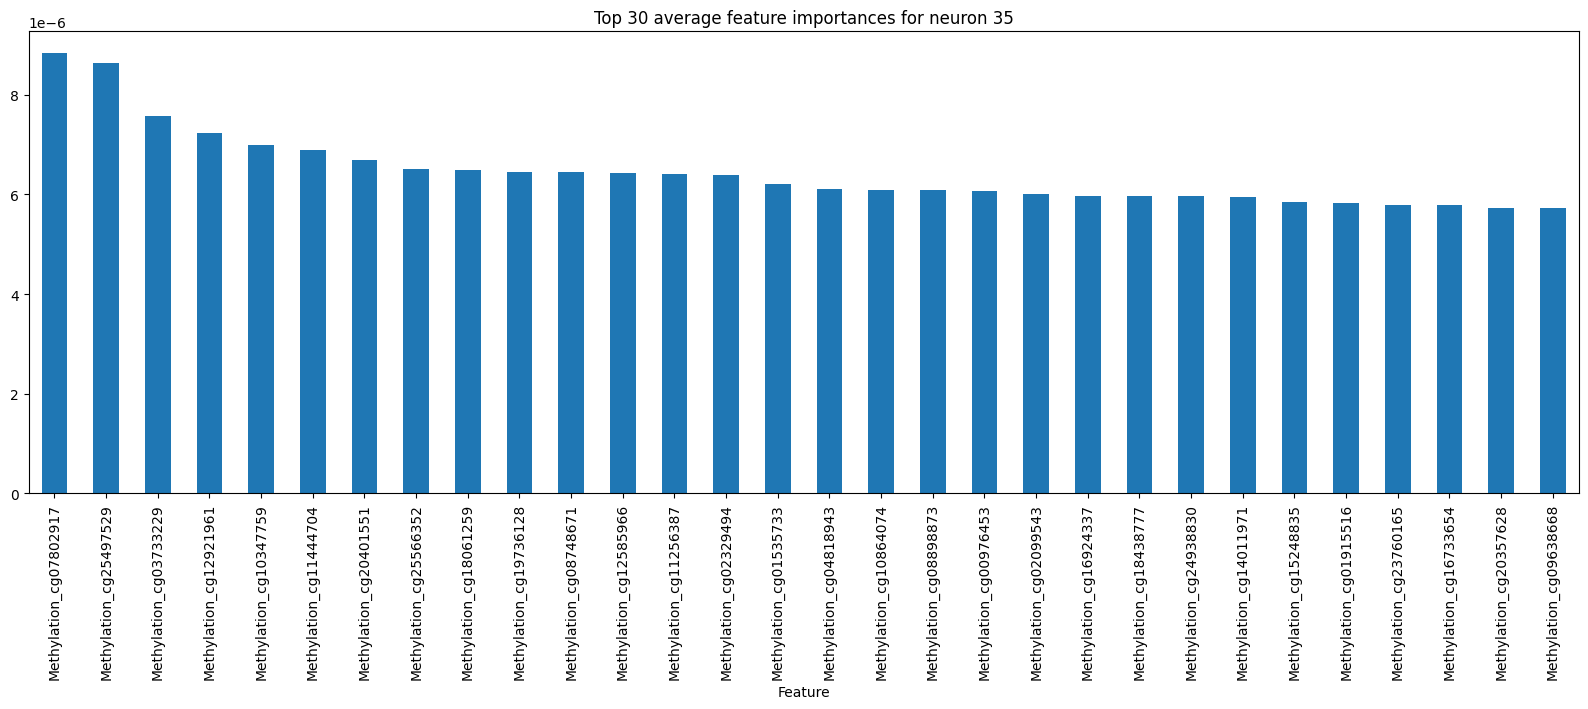

In [85]:
neuron_selector = sorted_neurons[0]
neuron_cond_vals = neuron_cond.attribute(inputs = inputs, baselines=baselines, target = target, neuron_selector= neuron_selector)
plot_feature_importance(features=features, top_n= 30, values= neuron_cond_vals, neuron_selector= neuron_selector, figsize= (20,6))

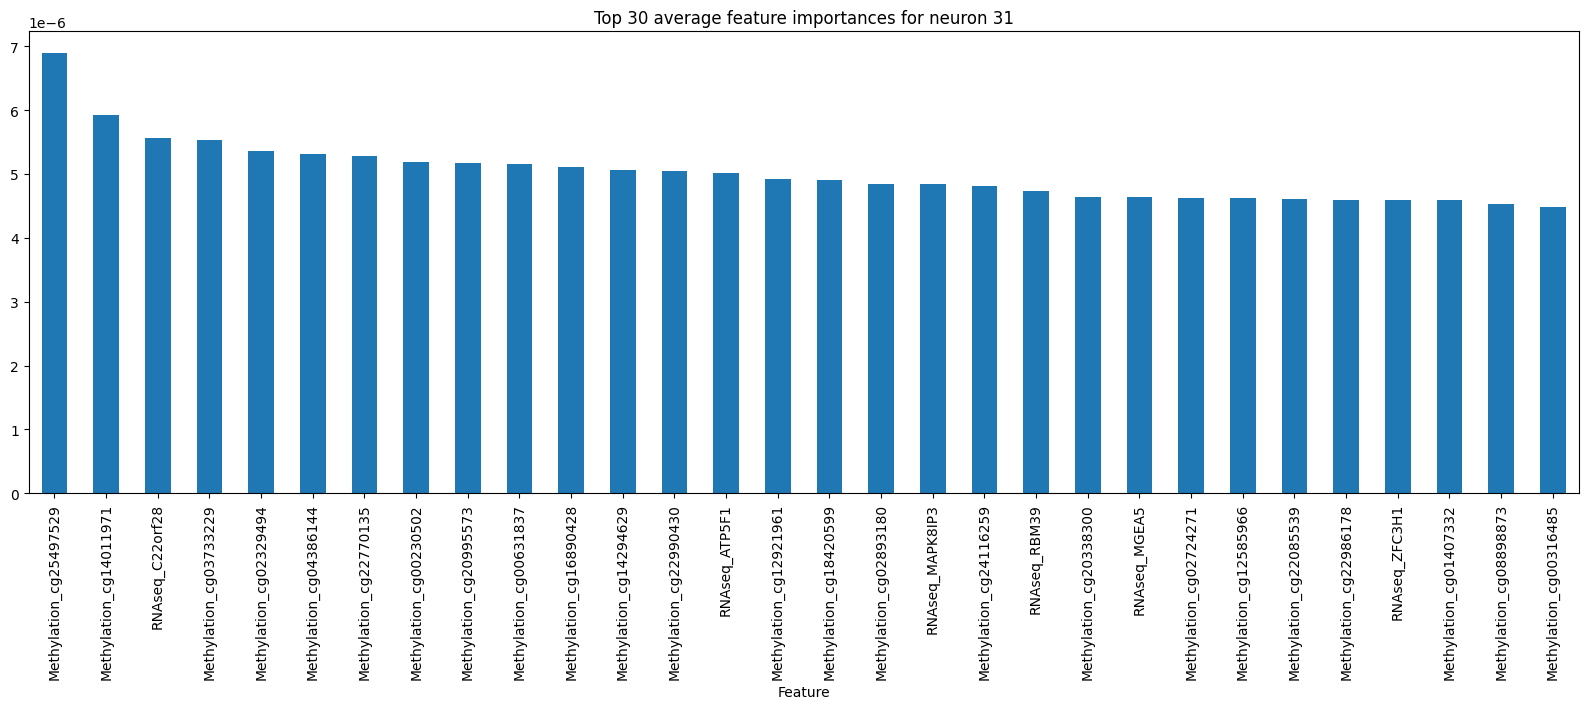

In [86]:
neuron_selector = sorted_neurons[1]
neuron_cond_vals = neuron_cond.attribute(inputs = inputs, baselines=baselines, target = target, neuron_selector= neuron_selector)
plot_feature_importance(features=features, top_n= 30, values= neuron_cond_vals, neuron_selector= neuron_selector, figsize= (20,6))

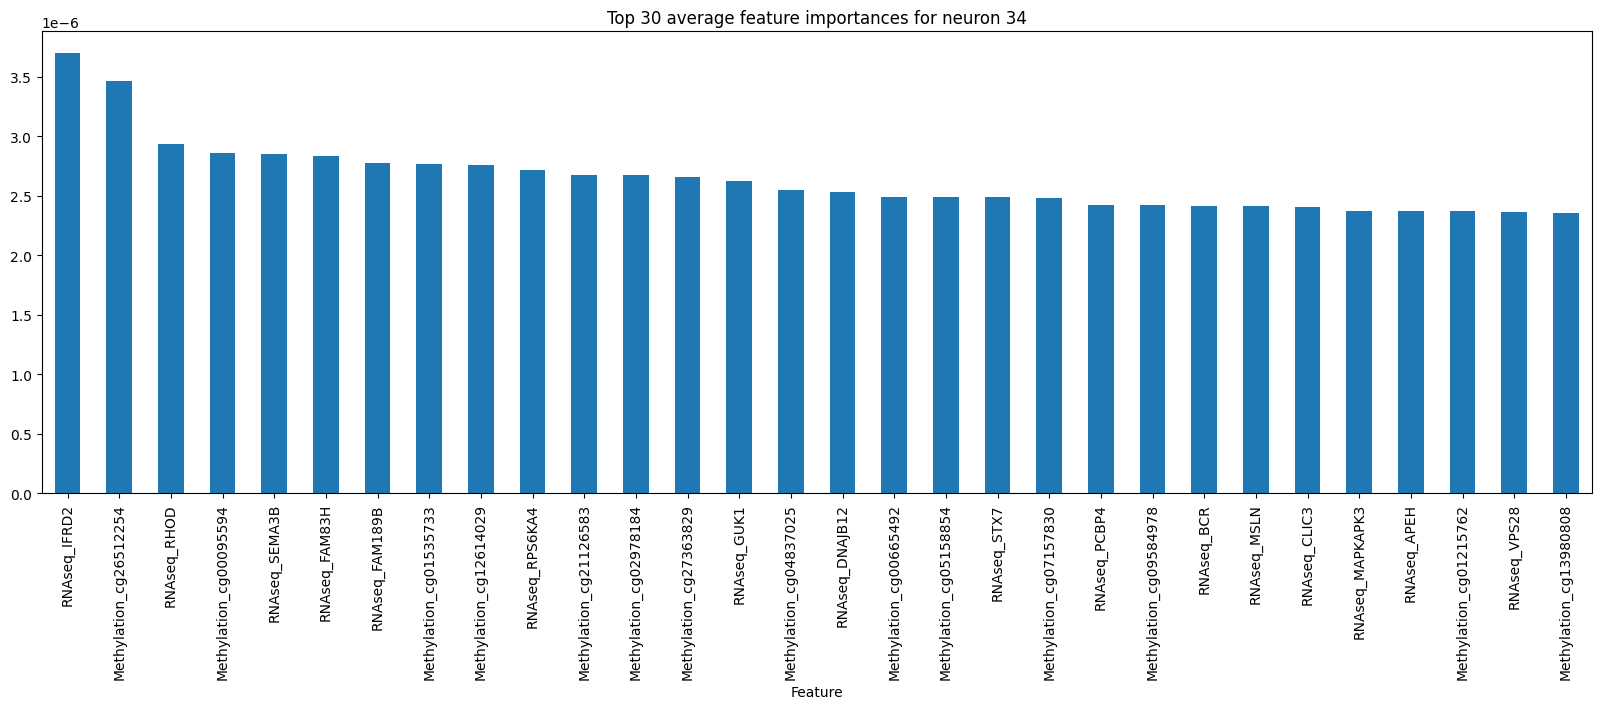

In [92]:
neuron_selector = sorted_neurons[3]
neuron_cond_vals = neuron_cond.attribute(inputs = inputs, baselines=baselines, target = target, neuron_selector= neuron_selector)
plot_feature_importance(features=features, top_n= 30, values= neuron_cond_vals, neuron_selector= neuron_selector, figsize= (20,6))

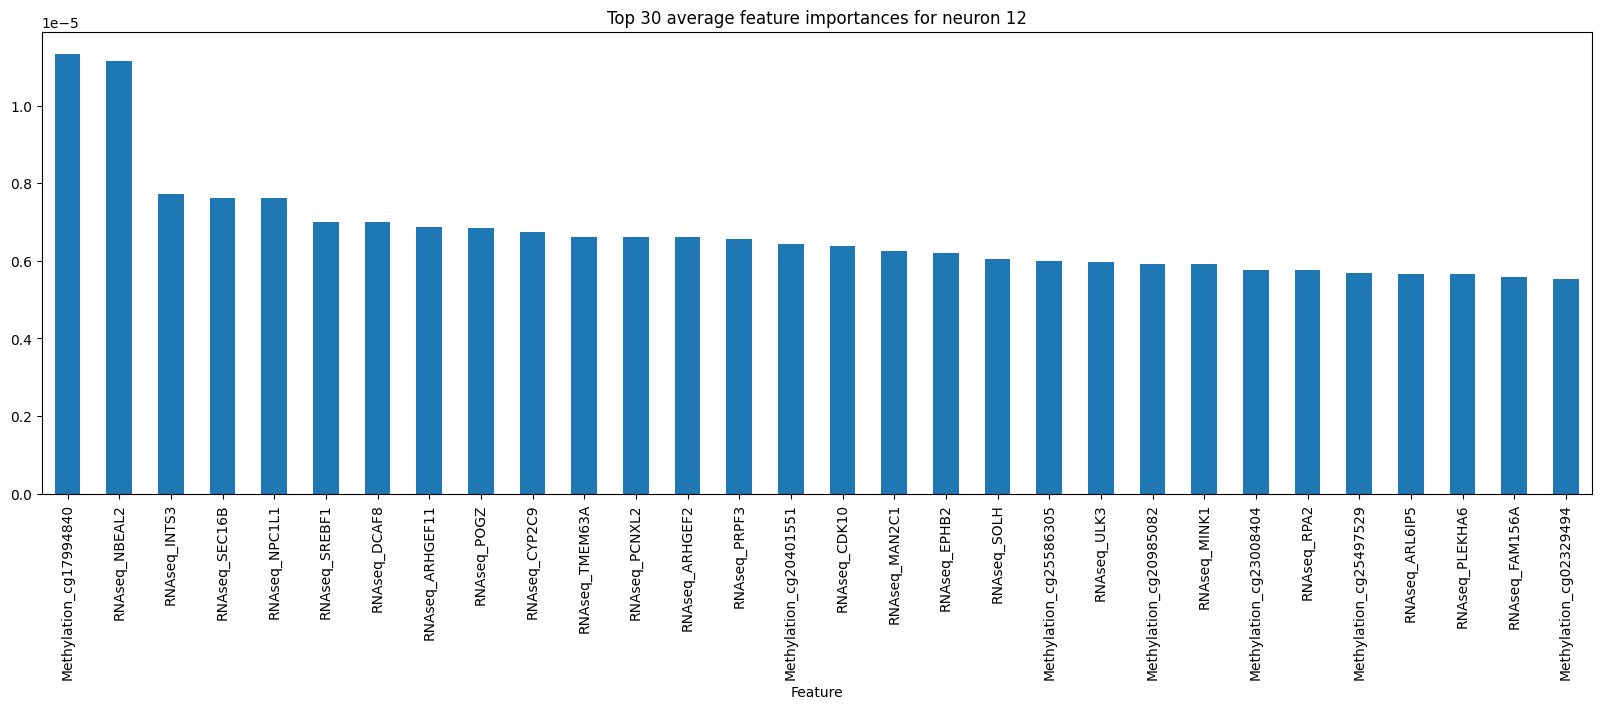

In [91]:
neuron_selector = sorted_neurons[7]
neuron_cond_vals = neuron_cond.attribute(inputs = inputs, baselines=baselines, target = target, neuron_selector= neuron_selector)
plot_feature_importance(features=features, top_n= 30, values= neuron_cond_vals, neuron_selector= neuron_selector, figsize= (20,6))

In [ ]:
lc._attribute = types.MethodType(_attribute, lc)

In [16]:
ig = IntegratedGradients(model.predict_step)
attr = ig.attribute(inputs = inputs, baselines=baselines, target = 1)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [14]:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

ig_attr_test = ig.attribute(inputs, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(inputs)
dl_attr_test = dl.attribute(inputs)
gs_attr_test = gs.attribute(inputs, inputs)
fa_attr_test = fa.attribute(inputs)

TypeError: DeepClustering.forward() takes 2 positional arguments but 3 were given

In [99]:
list(model.named_parameters())

[('autoencoder.encoder_0.hidden_0.0.weight',
  Parameter containing:
  tensor([[ 0.0080, -0.0048, -0.0133,  ..., -0.0199,  0.0210,  0.0084],
          [ 0.0048, -0.0058, -0.0002,  ...,  0.0076,  0.0049,  0.0152],
          [ 0.0042, -0.0036,  0.0176,  ..., -0.0023,  0.0050, -0.0274],
          ...,
          [-0.0143, -0.0014,  0.0130,  ...,  0.0133, -0.0071, -0.0064],
          [ 0.0291,  0.0051, -0.0066,  ...,  0.0063,  0.0012, -0.0048],
          [ 0.0092,  0.0077, -0.0205,  ...,  0.0131,  0.0097,  0.0049]],
         requires_grad=True)),
 ('autoencoder.encoder_0.hidden_0.0.bias',
  Parameter containing:
  tensor([-0.0077, -0.0039,  0.0120,  ..., -0.0040,  0.0119, -0.0026],
         requires_grad=True)),
 ('autoencoder.encoder_0.hidden_0.1.N.weight',
  Parameter containing:
  tensor([0.9897, 0.9856, 0.9999,  ..., 1.0136, 0.9997, 1.0012],
         requires_grad=True)),
 ('autoencoder.encoder_0.hidden_0.1.N.bias',
  Parameter containing:
  tensor([-0.0079, -0.0126,  0.0287,  ...,  0.0

In [112]:
masker = [pd.DataFrame(np.zeros_like(X_), index= X_.index, columns= X_.columns) for X_ in transformed_Xs]
explainer = GradientV2(model.predict_step, data = masker)
# shap_values = explainer(transformed_Xs)

AttributeError: 'function' object has no attribute 'eval'

In [105]:
model.named_parameters()

<generator object Module.named_parameters at 0x7f4ee4876f80>

In [111]:
from shap.explainers._gradient import Gradient, _PyTorchGradient

class GradientV2(Gradient):

    def __init__(self, model, data, session=None, batch_size=50, local_smoothing=0):
        framework = 'pytorch'

        if isinstance(data, pd.DataFrame):
            self.features = data.columns.values
        else:
            self.features = list(range(data[0].shape[1]))
        
        self.explainer = _PyTorchGradient(model, data, batch_size, local_smoothing)